# Brain Tumor Segmentation
**Model 11**

---

### importing

In [1]:
!pip install patchify
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      

In [3]:
import os
from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
from tqdm import tqdm

In [4]:
tf.__version__

'2.15.0'

### Modeling


In [8]:
def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])

    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

config = {}
config["image_size"] = 512
config["num_layers"] = 12
config["hidden_dim"] = 64
config["mlp_dim"] = 128
config["num_heads"] = 6
config["dropout_rate"] = 0.1
config["patch_size"] = 16
config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)
config["num_channels"] = 3

model = build_unetr_2d(config)
model.summary()

Model: "UNETR_2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1024, 768)]          0         []                            
                                                                                                  
 dense_50 (Dense)            (None, 1024, 64)             49216     ['input_3[0][0]']             
                                                                                                  
 tf.__operators__.add_2 (TF  (None, 1024, 64)             0         ['dense_50[0][0]']            
 OpLambda)                                                                                        
                                                                                                  
 layer_normalization_48 (La  (None, 1024, 64)             128       ['tf.__operators__.add_

### Metrics

In [9]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Training

In [10]:
""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.1):
    """ Loading the images and masks """
    X = sorted(glob(os.path.join(path, "images", "*.png")))
    Y = sorted(glob(os.path.join(path, "masks", "*.png")))

    """ Spliting the data into training and testing """
    split_size = int(len(X) * split)

    train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds


# if __name__ == "__main__":
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("/kaggle/working/files")

""" Hyperparameters """
batch_size = 8
lr = 0.1
num_epochs = 500
model_path = os.path.join("/kaggle/working/files", "model.h5")
csv_path = os.path.join("/kaggle/working/files", "log.csv")

""" Dataset """
dataset_path = "/kaggle/input/brain-tumor-segmentation"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

""" Model """
model = build_unetr_2d(cf)
model.compile(loss=dice_loss, optimizer=SGD(lr), metrics=[dice_coef, "acc"])
# model.summary()

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

results = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Train: 	2452 - 2452
Valid: 	306 - 306
Test: 	306 - 306
Epoch 1/500
307/307 [==============================] - 82s 194ms/step - loss: 0.9549 - dice_coef: 0.0451 - acc: 0.3929 - val_loss: 0.9438 - val_dice_coef: 0.0577 - val_acc: 0.6505 - lr: 0.1000
Epoch 2/500
307/307 [==============================] - 56s 183ms/step - loss: 0.9171 - dice_coef: 0.0828 - acc: 0.7732 - val_loss: 0.8945 - val_dice_coef: 0.1077 - val_acc: 0.8062 - lr: 0.1000
Epoch 3/500
307/307 [==============================] - 56s 183ms/step - loss: 0.8754 - dice_coef: 0.1245 - acc: 0.8803 - val_loss: 0.9419 - val_dice_coef: 0.0572 - val_acc: 0.9789 - lr: 0.1000
Epoch 4/500
307/307 [==============================] - 56s 183ms/step - loss: 0.8041 - dice_coef: 0.1958 - acc: 0.9609 - val_loss: 0.9579 - val_dice_coef: 0.0415 - val_acc: 0.9826 - lr: 0.1000
Epoch 5/500
307/307 [==============================] - 56s 183ms/step - loss: 0.7287 - dice_coef: 0.2711 - acc: 0.9760 - val_loss: 0.8807 - val_dice_coef: 0.1174 - val_acc: 

In [20]:
results.history.keys()

dict_keys(['loss', 'dice_coef', 'acc', 'val_loss', 'val_dice_coef', 'val_acc', 'lr'])

In [24]:
i = min(results.history['val_loss'])
i = results.history['val_loss'].index(i)

In [26]:
i

41

In [29]:
results.history['val_loss'][i]

0.3174557387828827

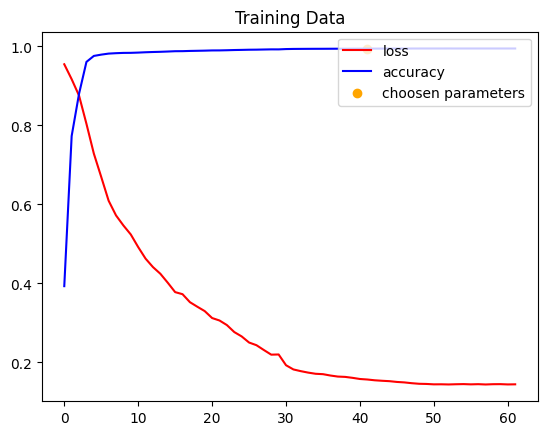

In [30]:
fig = plt.figure()
plt.plot(results.history['loss'], c='red', label='loss')
plt.plot(results.history['acc'], c='blue', label='accuracy')
plt.scatter(i ,results.history['acc'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Training Data")
plt.legend(loc="upper right")
plt.show()

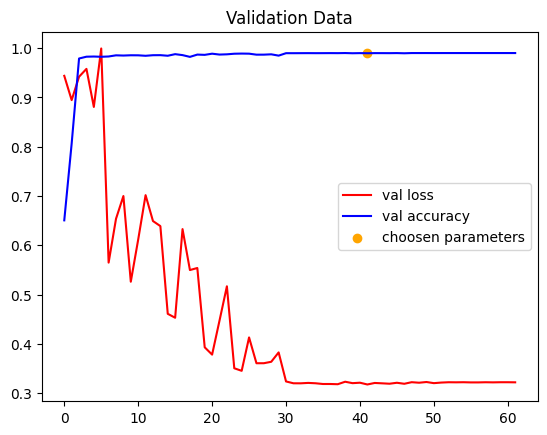

In [31]:
fig = plt.figure()
plt.plot(results.history['val_loss'], c='red', label='val loss')
plt.plot(results.history['val_acc'], c='blue', label='val accuracy')
plt.scatter(i ,results.history['val_acc'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Validation Data")
plt.legend(loc="center right")
plt.show()

In [13]:
model.save("/kaggle/working/brain_tumor_segmentation_model.h5")

In [14]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'brain_tumor_segmentation_model.h5')

/kaggle/working


/kaggle/working/brain_tumor_segmentation_model.h5

In [22]:
os.mkdir('/kaggle/working/results')

In [23]:
""" Dataset """
dataset_path = "/kaggle/input/brain-tumor-segmentation"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")

""" Prediction """
# for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
x = test_x[0]
y = test_y[0]
""" Extracting the name """
name = x.split("/")[-1]

""" Reading the image """
image = cv2.imread(x, cv2.IMREAD_COLOR)
image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
x = image / 255.0

patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
patches = patchify(x, patch_shape, cf["patch_size"])
patches = np.reshape(patches, cf["flat_patches_shape"])
patches = patches.astype(np.float32)
patches = np.expand_dims(patches, axis=0)

""" Read Mask """
mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
mask = mask / 255.0
mask = np.expand_dims(mask, axis=-1)
mask = np.concatenate([mask, mask, mask], axis=-1)

""" Prediction """
pred = model.predict(patches, verbose=0)[0]
pred = np.concatenate([pred, pred, pred], axis=-1)

""" Save final mask """
line = np.ones((cf["image_size"], 10, 3)) * 255
cat_images = np.concatenate([image, line, mask*255, line, pred*255], axis=1)

save_image_path = os.path.join("/kaggle/working/results",  name)
cv2.imwrite(save_image_path, cat_images)


Train: 	2452 - 2452
Valid: 	306 - 306
Test: 	306 - 306


True

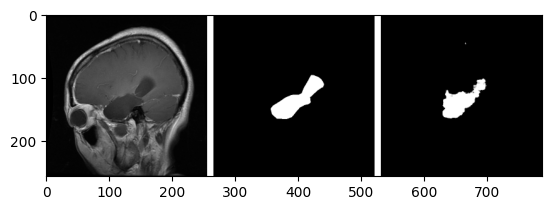

In [39]:
img = cv2.imread(r'/kaggle/working/results/3017.png')
plt.imshow(img)

In [57]:
def pred():
    """ Dataset """
    dataset_path = "/kaggle/input/brain-tumor-segmentation"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    
    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")
    
    """ Prediction """
    # for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    x = test_x[0]
    y = test_y[0]
    """ Extracting the name """
    name = x.split("/")[-1]
    
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    x = image / 255.0
    
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(x, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)
    
    """ Read Mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)
    
    """ Prediction """
    pred = model.predict(patches, verbose=0)[0]
    pred = np.concatenate([pred, pred, pred], axis=-1)*255
    
    
    alpha = 0.5  # Transparency factor
    segmented_image = cv2.addWeighted(image, 1, pred, alpha, 0)
    
    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Processed Mask")
    plt.imshow(mask_resized, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Segmented Tumor")
    plt.imshow(segmented_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


image,pred = pred()

Train: 	2452 - 2452
Valid: 	306 - 306
Test: 	306 - 306


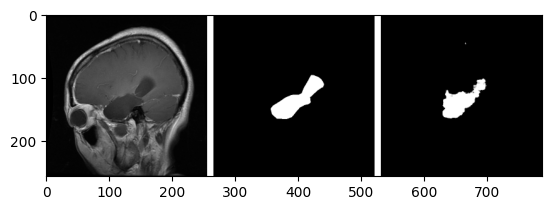

In [41]:
img = cv2.imread(r'/kaggle/working/results/3017.png')
plt.imshow(img)

In [59]:
save_image_path = os.path.join("/kaggle/working/results",  '1.png')
cv2.imwrite(save_image_path, image)
save_image_path = os.path.join("/kaggle/working/results",  '2.png')
cv2.imwrite(save_image_path, pred)

True

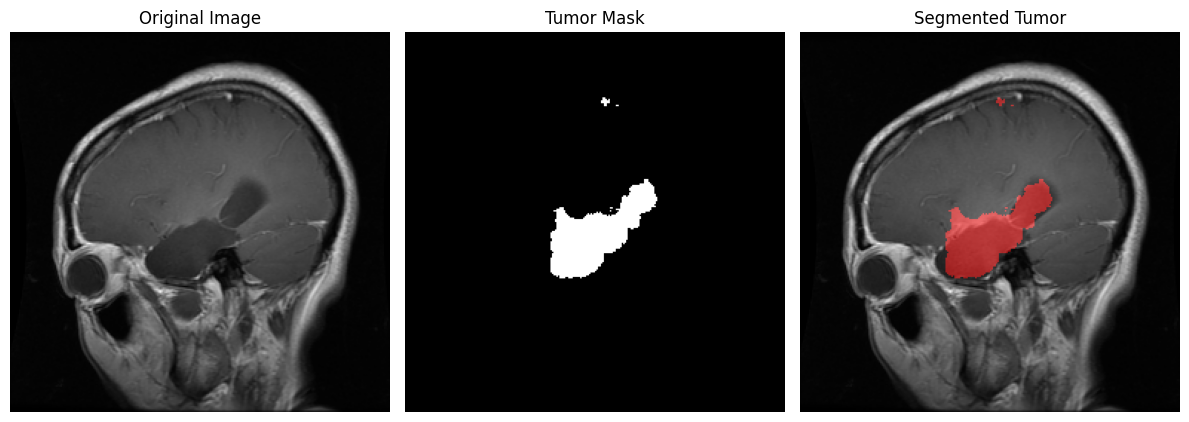

In [64]:
# Load the original image and mask (dummy example)
original_image = cv2.imread('/kaggle/working/results/1.png')  # RGB image
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

mask = cv2.imread('/kaggle/working/results/2.png', cv2.IMREAD_GRAYSCALE)  # Binary mask (0 or 255)

# Ensure mask is binary (0 and 1) and convert to uint8
mask = (mask > 0).astype(np.uint8)  # Convert to 0 and 1
mask = mask * 255  # Scale mask to 0 and 255 for visualization

# Convert mask to 3-channel to match the original image
mask_colored = cv2.merge((mask, np.zeros_like(mask), np.zeros_like(mask)))  # Red color mask

# Ensure both images are of type uint8
original_image = original_image.astype(np.uint8)
mask_colored = mask_colored.astype(np.uint8)

# Blend the original image and the mask
alpha = 0.5  # Transparency for the mask
segmented_image = cv2.addWeighted(original_image, 1, mask_colored, alpha, 0)
save_image_path = os.path.join("/kaggle/working/results",  'segmented_image.png')
cv2.imwrite(save_image_path, segmented_image)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Tumor Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Segmented Tumor")
plt.imshow(segmented_image)
plt.axis('off')

plt.tight_layout()
plt.show()


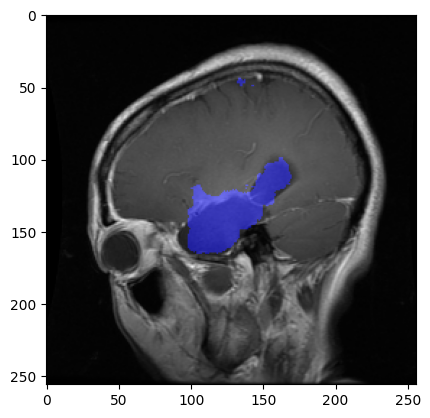

In [65]:
segmented_image = plt.imread('/kaggle/working/results/segmented_image.png')
plt.imshow(segmented_image)
plt.show()

---

In [1]:
def pred(image_path):

    """ UNETR  Configration """
    cf = {}
    cf["image_size"] = 256
    cf["num_channels"] = 3
    cf["num_layers"] = 12
    cf["hidden_dim"] = 128
    cf["mlp_dim"] = 32
    cf["num_heads"] = 6
    cf["dropout_rate"] = 0.1
    cf["patch_size"] = 16
    cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
    cf["flat_patches_shape"] = (
        cf["num_patches"],
        cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
    )
    
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    x = image / 255.0
    
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(x, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)
    
    pred = model.predict(patches, verbose=0)[0]
    pred = np.concatenate([pred, pred, pred], axis=-1)*255
    
    save_image_path = os.path.join("/kaggle/working/results",  'image.png')
    cv2.imwrite(save_image_path, image)
    save_image_path = os.path.join("/kaggle/working/results",  'mask.png')
    cv2.imwrite(save_image_path, pred)
    
    original_image = cv2.imread('/kaggle/working/results/image.png')  # RGB image
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    mask = cv2.imread('/kaggle/working/results/mask.png', cv2.IMREAD_GRAYSCALE)  # Binary mask (0 or 255)

    # Ensure mask is binary (0 and 1) and convert to uint8
    mask = (mask > 0).astype(np.uint8)  # Convert to 0 and 1
    mask = mask * 255  # Scale mask to 0 and 255 for visualization

    # Convert mask to 3-channel to match the original image
    mask_colored = cv2.merge((mask, np.zeros_like(mask), np.zeros_like(mask)))  # Red color mask
    
    # Ensure both images are of type uint8
    original_image = original_image.astype(np.uint8)
    mask_colored = mask_colored.astype(np.uint8)
    
    # Blend the original image and the mask
    alpha = 0.5  # Transparency for the mask
    segmented_image = cv2.addWeighted(original_image, 1, mask_colored, alpha, 0)
    save_image_path = os.path.join("/kaggle/working/results",  'segmented_image.png')
    cv2.imwrite(save_image_path, segmented_image)
    
    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Tumor Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Segmented Tumor")
    plt.imshow(segmented_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

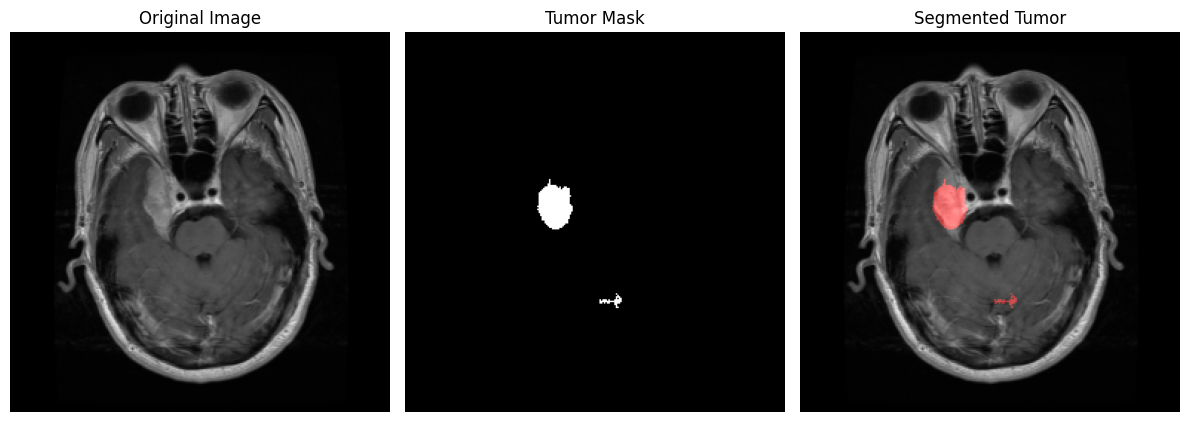

In [71]:
pred('/kaggle/input/brain-tumor-segmentation/images/100.png')

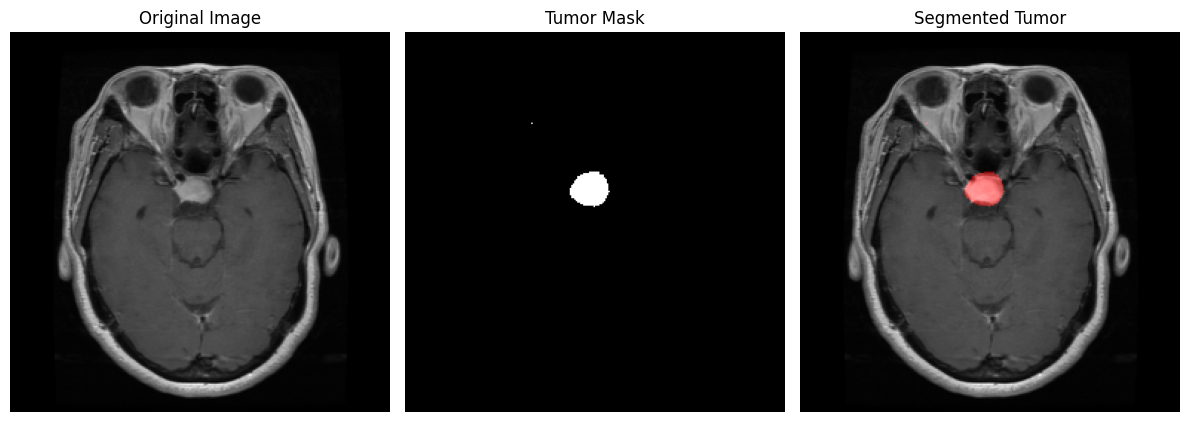

In [72]:
pred('/kaggle/input/brain-tumor-segmentation/images/1009.png')

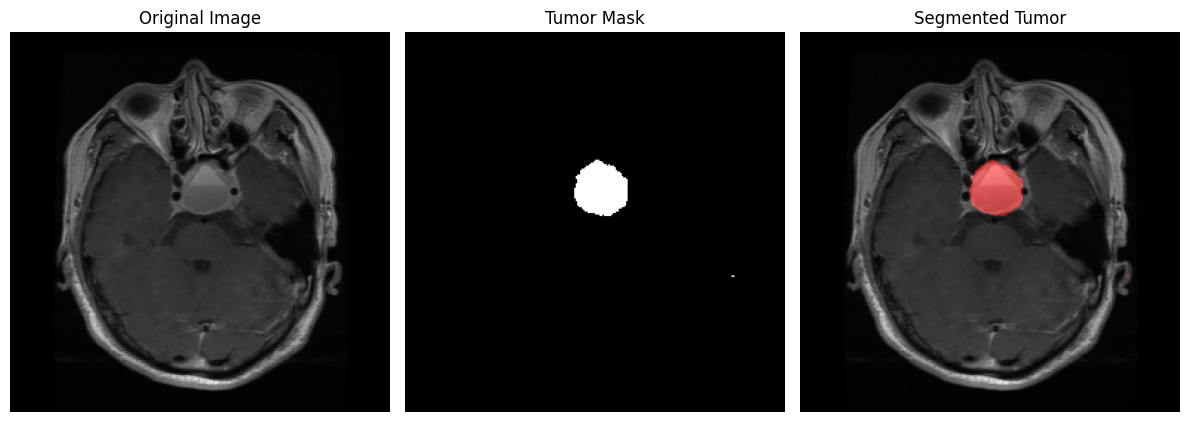

In [73]:
pred('/kaggle/input/brain-tumor-segmentation/images/1022.png')

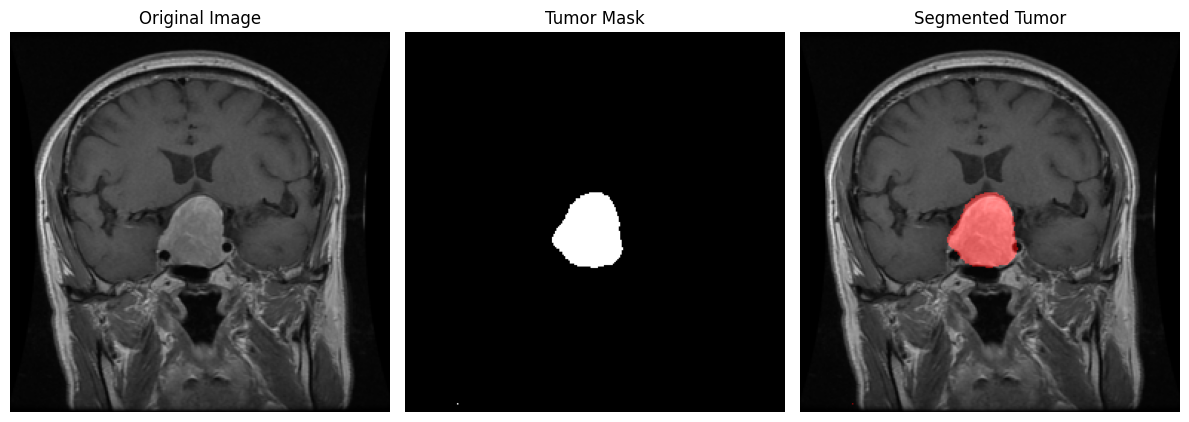

In [74]:
pred('/kaggle/input/brain-tumor-segmentation/images/1050.png')

---

In [1]:
print('test')

test


In [4]:
from run import BrainTumorSegmentation
brain = BrainTumorSegmentation()
# brain.pred(image_path=r"D:\STUDY\4th year\Graduation Project\AI\Final codes\test run samples\MRI brain meningioma tumor.jpg")

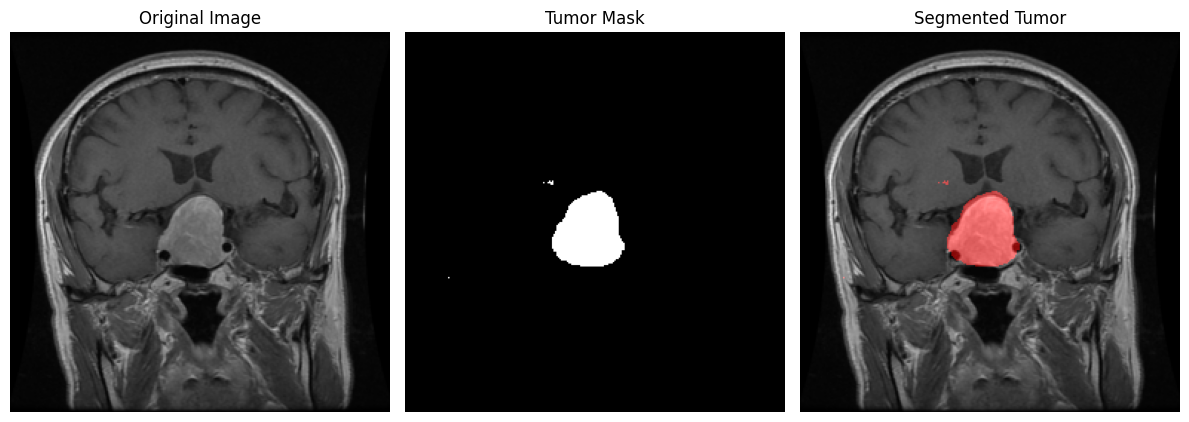

In [5]:
brain.predict(image_path='1050.png')

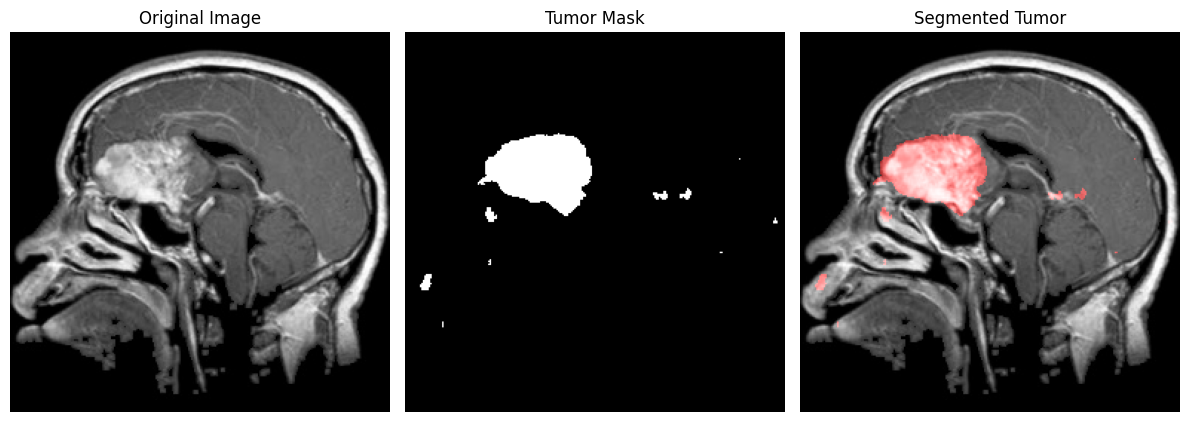

In [6]:
brain.predict(r"D:\STUDY\4th year\Graduation Project\AI\Final codes\test run samples\MRI brain glioma tumor.jpg")

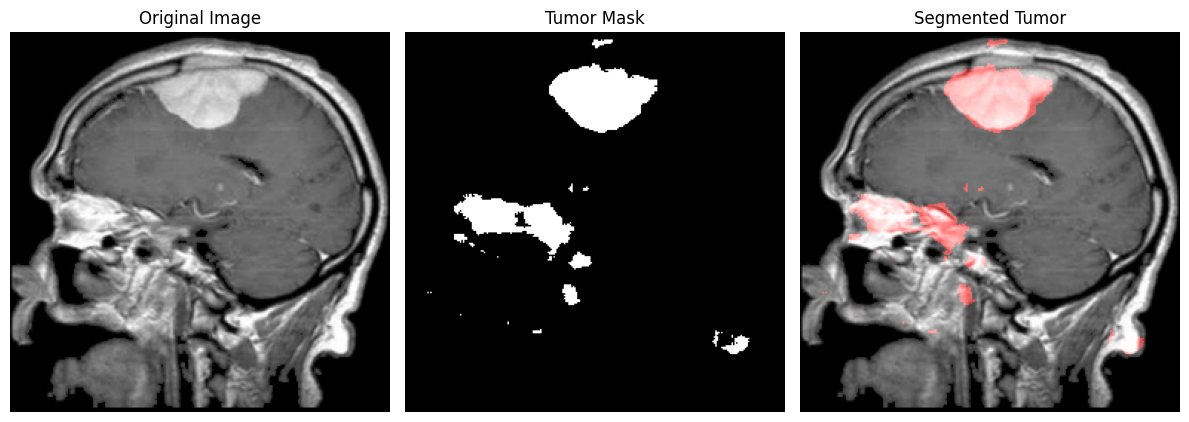

In [8]:
brain.predict(r"D:\STUDY\4th year\Graduation Project\AI\Final codes\test run samples\MRI brain meningioma tumor.jpg")